In [1]:
# ================================
# IMPORT LIBRARY
# ================================
import os
import shutil
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, GlobalAveragePooling2D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)

In [2]:
!unzip garbage_classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: garbage_classification/paper/paper381.jpg  
  inflating: garbage_classification/paper/paper382.jpg  
  inflating: garbage_classification/paper/paper383.jpg  
  inflating: garbage_classification/paper/paper384.jpg  
  inflating: garbage_classification/paper/paper385.jpg  
  inflating: garbage_classification/paper/paper386.jpg  
  inflating: garbage_classification/paper/paper387.jpg  
  inflating: garbage_classification/paper/paper388.jpg  
  inflating: garbage_classification/paper/paper389.jpg  
  inflating: garbage_classification/paper/paper39.jpg  
  inflating: garbage_classification/paper/paper390.jpg  
  inflating: garbage_classification/paper/paper391.jpg  
  inflating: garbage_classification/paper/paper392.jpg  
  inflating: garbage_classification/paper/paper393.jpg  
  inflating: garbage_classification/paper/paper394.jpg  
  inflating: garbage_classification/paper/paper395.jpg  
  inflating: garbage_classification/pa

In [3]:
# ================================
# DATASET SPLIT
# ================================
SOURCE_DIR = "garbage_classification"
BASE_DIR = "dataset_split"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

random.seed(42)

for class_name in os.listdir(SOURCE_DIR):
    class_path = os.path.join(SOURCE_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_end = int(0.7 * total)
    val_end = train_end + int(0.15 * total)

    splits = {
        TRAIN_DIR: images[:train_end],
        VAL_DIR: images[train_end:val_end],
        TEST_DIR: images[val_end:]
    }

    for split_dir, split_images in splits.items():
        class_split_dir = os.path.join(split_dir, class_name)
        os.makedirs(class_split_dir, exist_ok=True)
        for img in split_images:
            shutil.copy(
                os.path.join(class_path, img),
                os.path.join(class_split_dir, img)
            )

In [4]:
# ================================
# DATA GENERATOR
# ================================
IMG_SIZE = (160, 160)
BATCH_SIZE = 64
EPOCHS = 15

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_data = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_data = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = train_data.num_classes
CLASS_NAMES = list(train_data.class_indices.keys())

Found 10854 images belonging to 12 classes.
Found 2321 images belonging to 12 classes.
Found 2340 images belonging to 12 classes.


In [5]:
# ================================
# MODEL 1: CNN
# ================================
cnn_model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(160,160,3)),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(),
    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation="softmax")
])

cnn_model.compile(
    optimizer=Adam(0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# ================================
# MODEL 2: RESNET50 (FUNCTIONAL FIX)
# ================================
resnet_base = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(160,160,3)
)
resnet_base.trainable = False

x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

resnet_model = Model(
    inputs=resnet_base.input,
    outputs=output
)

resnet_model.compile(
    optimizer=Adam(0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# ================================
# MODEL 3: MOBILENETV2 (FUNCTIONAL FIX)
# ================================
mobilenet_base = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(160,160,3)
)
mobilenet_base.trainable = False

x = mobilenet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

mobilenet_model = Model(
    inputs=mobilenet_base.input,
    outputs=output
)

mobilenet_model.compile(
    optimizer=Adam(0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# ================================
# TRAINING
# ================================
callback = EarlyStopping(
    patience=3,
    restore_best_weights=True
)

history_cnn = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[callback]
)

history_resnet = resnet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[callback]
)

history_mobilenet = mobilenet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[callback]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 668s 4s/step - accuracy: 0.3671 - loss: 2.0050 - val_accuracy: 0.5631 - val_loss: 1.3023
Epoch 2/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 650s 4s/step - accuracy: 0.5453 - loss: 1.4060 - val_accuracy: 0.6303 - val_loss: 1.1354
Epoch 3/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 654s 4s/step - accuracy: 0.5937 - loss: 1.2391 - val_accuracy: 0.6502 - val_loss: 1.0878
Epoch 4/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 651s 4s/step - accuracy: 0.6228 - loss: 1.1610 - val_accuracy: 0.7006 - val_loss: 0.9179
Epoch 5/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 652s 4s/step - accuracy: 0.6468 - loss: 1.0700 - val_accuracy: 0.6635 - val_loss: 1.0282
Epoch 6/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 649s 4s/step - accuracy: 0.6683 - loss: 1.0342 - val_accuracy: 0.7087 - val_loss: 0.9093
Epoch 7/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 654s 4s/step - accuracy: 0.6700 - loss: 1.0081 - val_accuracy: 0.7217 - val_loss: 0.8638
Epoch 8/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 653s 4s/step - accuracy: 0.6885 - loss: 0.9563 - val_accu

In [11]:
# ================================
# EVALUATION FUNCTION
# ================================
def evaluate_model(model, history, model_name, save_dir="evaluation"):
    os.makedirs(save_dir, exist_ok=True)

    y_pred = np.argmax(model.predict(test_data), axis=1)
    y_true = test_data.classes

    report = classification_report(
        y_true, y_pred,
        target_names=CLASS_NAMES,
        output_dict=True
    )

    accuracy = accuracy_score(y_true, y_pred)

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1_score": report["weighted avg"]["f1-score"]
    }

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    with open(f"{save_dir}/{model_name}_metrics.json", "w") as f:
        json.dump(metrics, f, indent=2)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=CLASS_NAMES,
                yticklabels=CLASS_NAMES)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.savefig(f"{save_dir}/{model_name}_confusion_matrix.png")
    plt.show()

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Train")
    plt.plot(history.history["val_accuracy"], label="Val")
    plt.title(f"Accuracy - {model_name}")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Val")
    plt.title(f"Loss - {model_name}")
    plt.legend()

    plt.savefig(f"{save_dir}/{model_name}_training_curve.png")
    plt.show()

    return metrics

37/37 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

Classification Report:
              precision    recall  f1-score   support

     battery       0.65      0.70      0.67       143
  biological       0.74      0.84      0.79       149
 brown-glass       0.82      0.72      0.77        92
   cardboard       0.73      0.84      0.78       135
     clothes       0.86      0.96      0.91       800
 green-glass       0.91      0.82      0.86        95
       metal       0.43      0.44      0.43       116
       paper       0.67      0.68      0.67       158
     plastic       0.57      0.46      0.51       131
       shoes       0.81      0.65      0.72       298
       trash       0.76      0.59      0.67       106
 white-glass       0.64      0.52      0.58       117

    accuracy                           0.76      2340
   macro avg       0.72      0.68      0.70      2340
weighted avg       0.76      0.76      0.76      2340



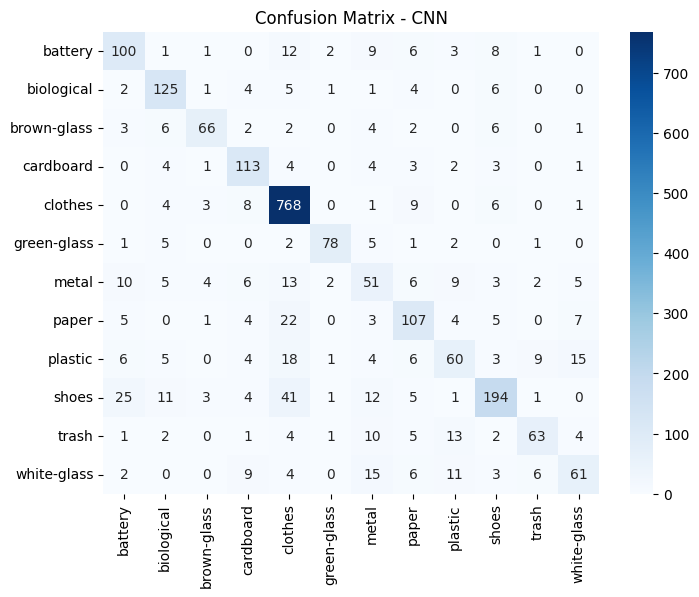

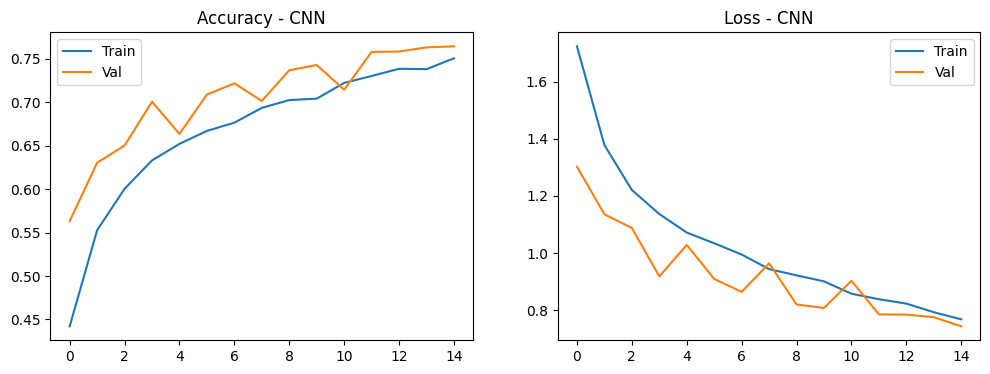

37/37 ━━━━━━━━━━━━━━━━━━━━ 213s 6s/step

Classification Report:
              precision    recall  f1-score   support

     battery       0.55      0.43      0.48       143
  biological       0.00      0.00      0.00       149
 brown-glass       0.30      0.08      0.12        92
   cardboard       0.00      0.00      0.00       135
     clothes       0.39      0.96      0.56       800
 green-glass       0.00      0.00      0.00        95
       metal       0.00      0.00      0.00       116
       paper       0.00      0.00      0.00       158
     plastic       0.00      0.00      0.00       131
       shoes       0.33      0.29      0.31       298
       trash       0.00      0.00      0.00       106
 white-glass       0.00      0.00      0.00       117

    accuracy                           0.39      2340
   macro avg       0.13      0.15      0.12      2340
weighted avg       0.22      0.39      0.26      2340



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

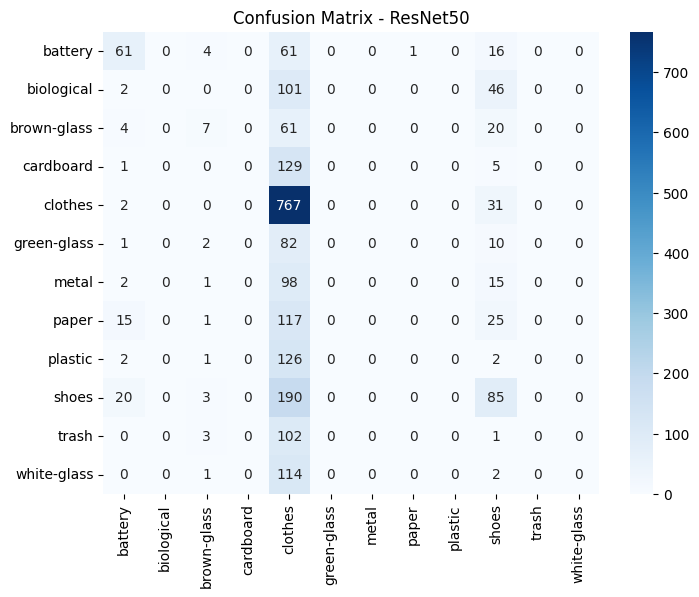

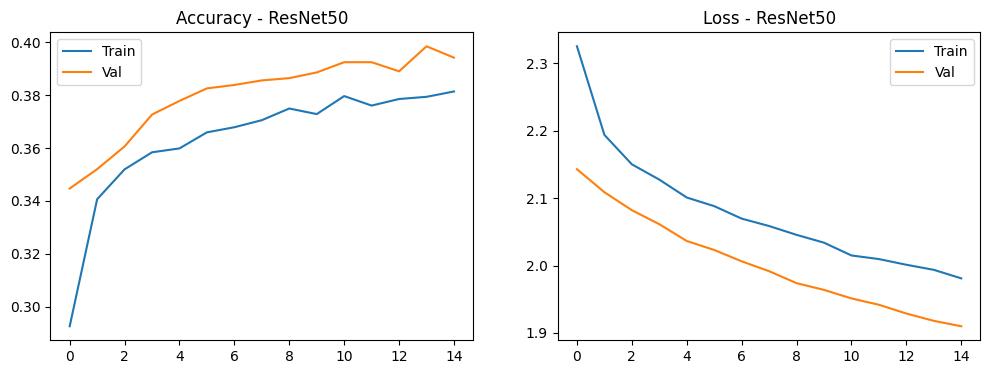

37/37 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step

Classification Report:
              precision    recall  f1-score   support

     battery       0.92      0.90      0.91       143
  biological       0.99      0.92      0.95       149
 brown-glass       0.89      0.84      0.86        92
   cardboard       0.90      0.91      0.90       135
     clothes       0.97      0.99      0.98       800
 green-glass       0.88      0.83      0.85        95
       metal       0.70      0.84      0.76       116
       paper       0.91      0.91      0.91       158
     plastic       0.72      0.76      0.74       131
       shoes       0.92      0.96      0.94       298
       trash       0.98      0.83      0.90       106
 white-glass       0.76      0.63      0.69       117

    accuracy                           0.91      2340
   macro avg       0.88      0.86      0.87      2340
weighted avg       0.91      0.91      0.91      2340



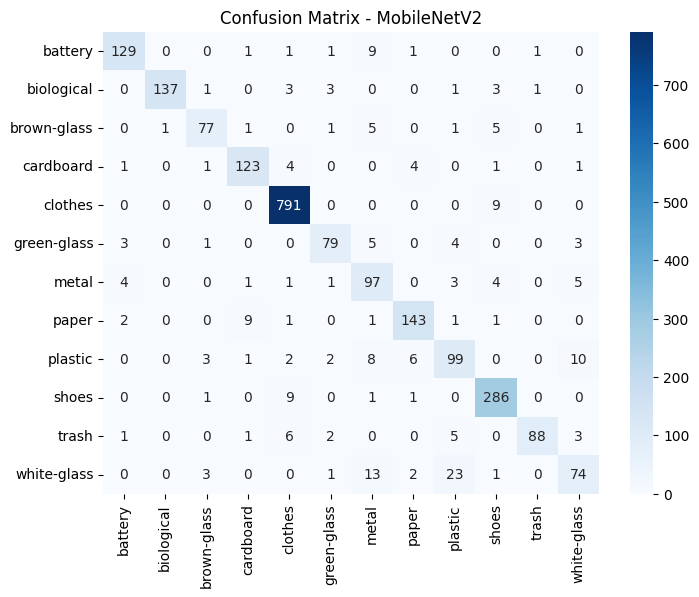

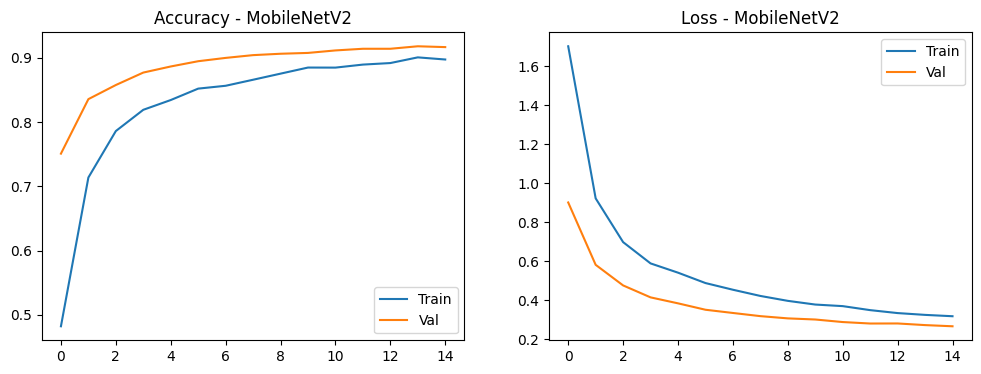

In [12]:
# ================================
# RUN EVALUATION
# ================================
all_evaluations = {}

all_evaluations["CNN"] = evaluate_model(cnn_model, history_cnn, "CNN")
all_evaluations["ResNet50"] = evaluate_model(resnet_model, history_resnet, "ResNet50")
all_evaluations["MobileNetV2"] = evaluate_model(mobilenet_model, history_mobilenet, "MobileNetV2")

In [13]:
# ================================
# SAVE FOR STREAMLIT
# ================================
os.makedirs("models", exist_ok=True)

with open("models/evaluation.json", "w") as f:
    json.dump(all_evaluations, f, indent=2)

cnn_model.save("models/cnn_model.keras")
resnet_model.save("models/resnet_model.keras")
mobilenet_model.save("models/mobilenet_model.keras")

np.save("models/class_names.npy", CLASS_NAMES)

print("TRAINING & EVALUATION SELESAI - MODEL SIAP DEPLOY")

TRAINING & EVALUATION SELESAI - MODEL SIAP DEPLOY
